# Exploring Policies
In this notebook, I explore the 

### About the policies
ABAC policy file has extension .abac.
* userAttrib(uid, attribute1=value1, attribute2=value2, ...): is automatically assigned to an attribute named "uid".
* resourceAttrib(rid, attribute1=value1, attribute2=value2, ...): is automatically assigned to an attribute named "rid".
* rule(ruleName; uae; pae; ops; con)
* unremovableUserAttribs(attribute1, attribute2, ...)
* unremovableResourceAttribs(attribute1, attribute2, ...)

*value1, value2,... are atomic values or sets.*
* an ***atomic*** value is a string that starts with a character other than a left curly brace.
* a ***set*** has the form "{element1 element2 ...}".  note that elements of a set are separated by spaces, not commas.

***uae*** is a user attribute expression. it is a conjunction, with the conjuncts separated by commas.
* each conjunct has the form $a \in \{value1, value2, \dots \}$ where $a$ is a *single-valued* user attribute, or 
* $a \subseteq \{set1, set2, \dots \}$ (meaning that $a$ is a *superset* of one of the sets in *{set1 set2 ...}*) where $a$ is a *multi-valued* user attribute, and *set1, set2, ...,* are sets of the form *{value1+value2+...}*".
* note that sets (such as set1, set2, ...) that are nested inside another set are written with the elements separated by "+" (instead of " ") to simplify parsing.

***rae*** is a resource attribute expression.  the syntax is analogous to the syntax for user attribute expressions.

***ops*** is a set of operations.

***con*** is a constraint.
* it is a conjunction of atomic constraints, with the conjuncts separated by commas.
* an *atomic constraint* is a formula of the form "*aum > arm, aum ] ars*", or *aus=ars$*, where
    * **aus** is a single-valued user
    * **aum** is a multi-valued user attribute,
    * **ars** is a single-valued resource attribute, and
    * **arm** is a multi-valued resource attribute.
* note that $>$ denotes $\supseteq$ and "]" denotes $\ni$.

the sets of users, resources, operations, user attributes, permission attributes, **are not specified explicitly**.  They are implicitly defined as the sets containing the users, permissions, etc., that are mentioned in the policy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from pathlib import Path
import matplotlib as mpl

### Healthcare

In [137]:
# Load user and resource data
filepath = "../data/HC-users.csv"
df_users = pd.read_csv(filepath) # Users
#df_users = df_users[df_users.columns[1:]] # remove the rname column
df_users = df_users.drop_duplicates() # Remove deplicated users

filepath = "../data/HC-res.csv"
df_res = pd.read_csv(filepath)  # Resources
df_res = df_res[df_res.columns[1:]]
df_res = df_res.drop_duplicates() # Remove deplicated users

print(df_users.info(), df_res.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uname        31 non-null     object
 1   position     31 non-null     object
 2   uward        31 non-null     object
 3   specialties  31 non-null     object
 4   teams        31 non-null     object
 5   agentfor     31 non-null     object
dtypes: object(6)
memory usage: 1.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 0 to 30
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   type         31 non-null     object
 1   author       31 non-null     object
 2   patient      31 non-null     object
 3   topics       31 non-null     object
 4   tratingTeam  31 non-null     object
 5   rward        31 non-null     object
dtypes: object(6)
memory usage: 1.7+ KB
None None


In [138]:
result = 1
for col_name in df_res:
    unique_values = df_res[col_name].value_counts().size
    print(col_name, unique_values)
    result = result * unique_values
print(result)

result = 1
for col_name in df_users:
    unique_values = df_users[col_name].value_counts().size
    print(col_name, unique_values)
    result = result * unique_values
print(result)

type 2
author 31
patient 4
topics 5
tratingTeam 4
rward 2
9920
uname 31
position 3
uward 3
specialties 6
teams 5
agentfor 3
25110


In [139]:
uniques = [df_res[i].unique().tolist() for i in df_res.columns]
df_res = pd.DataFrame(product(*uniques), columns = df_res.columns)
df_res["rname"] = df_res.index
df_res

,type,author,patient,topics,tratingTeam,rward,rname
0,HRitem,oncNurse1,oncPat1,oncology,oncTeam1,oncward,0
1,HRitem,oncNurse1,oncPat1,oncology,oncTeam1,carward,1
2,HRitem,oncNurse1,oncPat1,oncology,oncTeam2,oncward,2
3,HRitem,oncNurse1,oncPat1,oncology,oncTeam2,carward,3
4,HRitem,oncNurse1,oncPat1,oncology,carTeam1,oncward,4
...,...,...,...,...,...,...,...
9915,HR,carAgent1,carPat2,cardiology,oncTeam2,carward,9915
9916,HR,carAgent1,carPat2,cardiology,carTeam1,oncward,9916
9917,HR,carAgent1,carPat2,cardiology,carTeam1,carward,9917
9918,HR,carAgent1,carPat2,cardiology,carTeam2,oncward,9918


In [17]:
uniques = [df_users[i].unique().tolist() for i in df_users.columns]
df_users = pd.DataFrame(product(*uniques), columns = df_users.columns)
df_users["uname"] = df_users.index
df_users

,position,uward,specialties,teams,agentfor,uname
0,nurse,oncward,None,None,None,0
1,nurse,oncward,None,None,oncPat2,1
2,nurse,oncward,None,None,carPat2,2
3,nurse,oncward,None,oncTeam2,None,3
4,nurse,oncward,None,oncTeam2,oncPat2,4
...,...,...,...,...,...,...
805,None,None,neurology,carTeam1,oncPat2,805
806,None,None,neurology,carTeam1,carPat2,806
807,None,None,neurology,carTeam2,None,807
808,None,None,neurology,carTeam2,oncPat2,808


In [140]:
# 0 = attribute = value
# 1 = attribute = attribute => attribute.value = attribute.value
# 2 = value in attribute => a in {a, b, c}
policy = [
    [
        [0, "position", "nurse"],
        [0, "type", "HR"],
        [1, "uward", "rward"]
    ],
    [
        [0, "type", "HR"],
        [1, "tratingTeam", "teams"]
    ],
    [
        [0, "type", "HR"],
        [1, "uname", "patient"]
    ],
    [
        [0, "type", "HR"],
        [1, "patient", "agentfor"]
    ],

    [
        [0, "type", "HRItem"],
        [1, "uname", "author"]
    ],
    [
        [0, "position", "nurse"],
        [0, "type", "HRItem"],
        [0, "topics", "nursing"],
        [1, "uward", "rward"]
    ],
    [
        [0, "type", "HRItem"],
        [1, "topics", "specialties"],
        [1, "tratingTeam", "teams"]
    ],
    [
        [0, "type", "HRItem"],
        [0, "topics", "note"],
        [1, "uname", "patient"]
    ],
    [
        [0, "type", "HRItem"],
        [0, "topics", "note"],
        [1, "patient", "agentfor"]
    ]
]

In [150]:
counter_len = 0
for rule in policy:
    counter_len += len(rule)
print("|R|", len(policy))
print("avg(R)", counter_len/len(policy))
print("WSC", counter_len)


|R| 9
avg(R) 2.6666666666666665
WSC 24


In [142]:
access_log = []
for user in df_users.values:
    for res in df_res.values:        
        access_log.append(list(user) + list(res))
        
access_log = pd.DataFrame(access_log)
access_log.columns = df_users.columns.append(df_res.columns)
access_log

,uname,position,uward,specialties,teams,agentfor,type,author,patient,topics,tratingTeam,rward,rname
0,oncNurse1,nurse,oncward,None,None,None,HRitem,oncNurse1,oncPat1,oncology,oncTeam1,oncward,0
1,oncNurse1,nurse,oncward,None,None,None,HRitem,oncNurse1,oncPat1,oncology,oncTeam1,carward,1
2,oncNurse1,nurse,oncward,None,None,None,HRitem,oncNurse1,oncPat1,oncology,oncTeam2,oncward,2
3,oncNurse1,nurse,oncward,None,None,None,HRitem,oncNurse1,oncPat1,oncology,oncTeam2,carward,3
4,oncNurse1,nurse,oncward,None,None,None,HRitem,oncNurse1,oncPat1,oncology,carTeam1,oncward,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307515,carAgent1,None,None,None,None,carPat2,HR,carAgent1,carPat2,cardiology,oncTeam2,carward,9915
307516,carAgent1,None,None,None,None,carPat2,HR,carAgent1,carPat2,cardiology,carTeam1,oncward,9916
307517,carAgent1,None,None,None,None,carPat2,HR,carAgent1,carPat2,cardiology,carTeam1,carward,9917
307518,carAgent1,None,None,None,None,carPat2,HR,carAgent1,carPat2,cardiology,carTeam2,oncward,9918


In [143]:
false_negs = []
positive_ar = []
for row in access_log.iloc:
    # Evaluation
    denies_count = 0    
    for rule in policy:
        res = True

        for item_rule in rule:    
            if item_rule[0] == 0:# Check type of typle => Attr=Value
                if row[item_rule[1]] != item_rule[2]:
                    res = False
                    break
            if item_rule[0] == 1: # => attr1.val = attr2.val
                if row[item_rule[1]] != row[item_rule[2]]:
                    res = False
                    break
            if item_rule[0] == 2: # val1 in {val1, val2, val3}
                if not row[item_rule[1]] in row[item_rule[2]]:
                    res = False
                    break
        if res == False:
            denies_count += 1
    if denies_count == len(policy):        
        false_negs.append(row)
    else:
        positive_ar.append(row)

false_negs = pd.DataFrame(false_negs)
positive_ar = pd.DataFrame(positive_ar)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
print("FN;", len(false_negs), "\t\tTP:", len(positive_ar))


FN; 272800 		TP: 34720


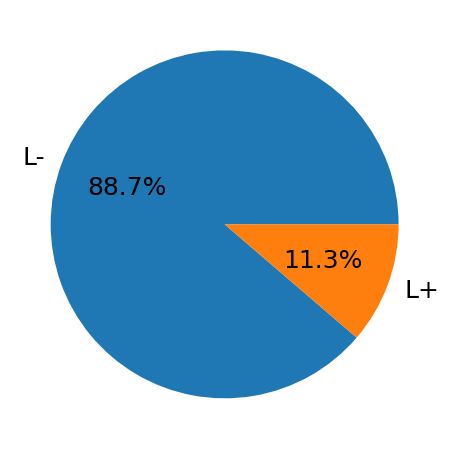

In [151]:
sizes = [272800, 34720]
fontdict_labels = {'fontsize': 25}
fig, ax = plt.subplots(figsize=(8,8))
color_palette = ['#1e81b0', '#e28743', '#9BC1BC', '#5CA4A9', '#E6EBE0']
color_palette = ['#5CA4A9', '#ED6A5A', '#9BC1BC', '#5CA4A9', '#E6EBE0']
ax.pie(sizes, labels=["L-","L+"],
        autopct='%1.1f%%', textprops=fontdict_labels)
plt.show()

In [145]:
false_negs.to_csv("../data/HC-ALL-negative_ar.csv")
positive_ar.to_csv("HC-ALL-positive_ar.csv")

del false_negs
del positive_ar

In [152]:
#pos_ar = pd.read_csv("../data/HC-ALL-positive_ar.csv")
pos_ar = pd.read_csv("HC-ALL-positive_ar.csv")
print(pos_ar.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34720 entries, 0 to 34719
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   34720 non-null  int64 
 1   uname        34720 non-null  object
 2   position     34720 non-null  object
 3   uward        34720 non-null  object
 4   specialties  34720 non-null  object
 5   teams        34720 non-null  object
 6   agentfor     34720 non-null  object
 7   type         34720 non-null  object
 8   author       34720 non-null  object
 9   patient      34720 non-null  object
 10  topics       34720 non-null  object
 11  tratingTeam  34720 non-null  object
 12  rward        34720 non-null  object
 13  rname        34720 non-null  int64 
dtypes: int64(2), object(12)
memory usage: 3.7+ MB
None


In [155]:
len(pos_ar.uname.value_counts())

26

In [156]:
fpath = Path(mpl.get_data_path(), "C:\\Users\\danie\\AppData\\Local\\Microsoft\\Windows\\Fonts\\mulish-regular.ttf")
fpath2 = Path(mpl.get_data_path(), "C:\\Users\\danie\\AppData\\Local\\Microsoft\\Windows\\Fonts\\mulish-regular.ttf")


In [116]:
pos_ar.rname.drop_duplicates()

0        2080
1        2082
2        2084
3        2086
4        2088
         ... 
17764    4087
17769    4095
17774    4103
17779    4111
17784    4119
Name: rname, Length: 2080, dtype: int64

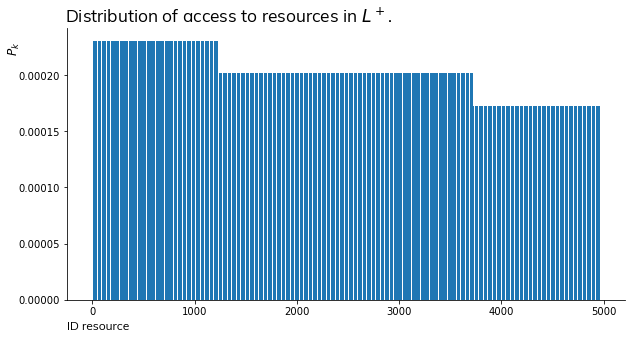

In [157]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = pos_ar.rname.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('ID resource', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of access to resources in $L^+$.", size="xx-large",  font=fpath2, x=0.29, y=1, parse_math=True)
plt.savefig("HC-AccessDistribution.svg")
plt.show()

In [9]:
pos_ar.uname.drop_duplicates()

0           0
1040        1
2340        2
3640        3
4940        4
         ... 
682240    805
683150    806
684060    807
684580    808
685490    809
Name: uname, Length: 768, dtype: int64

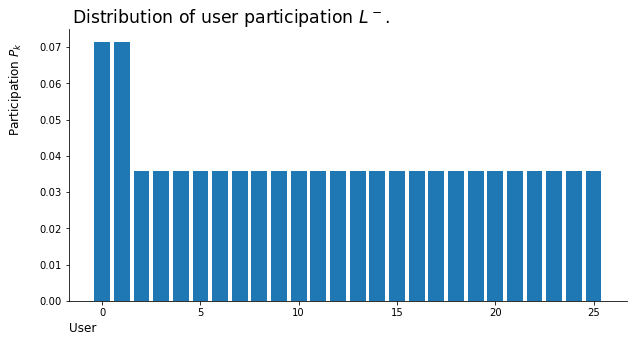

In [158]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = pos_ar.uname.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('User', loc="left", size="large")
ax.set_ylabel('Participation $P_k$', loc="top", size="large")
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of user participation $L^-$.", size="xx-large", x=0.29, y=1)
plt.savefig("HC-UserDistri.svg")
plt.show()

In [147]:
a = false_negs[false_negs.type=="HR"]
a = a[a.teams!="None"]
a[["teams", "tratingTeam"]]

,teams,tratingTeam
71,oncTeam1,oncTeam2
75,oncTeam1,carTeam1
79,oncTeam1,carTeam2
83,oncTeam2,oncTeam1
91,oncTeam2,carTeam1
95,oncTeam2,carTeam2
103,oncTeam1,oncTeam2
107,oncTeam1,carTeam1
111,oncTeam1,carTeam2
115,oncTeam2,oncTeam1


In [52]:
class User:
    def __init__(self, name, position , uward , specialties , teams , agentfor) -> None:
        self.name = name
        self.position = position
        self.ward = uward
        self.specialties = specialties
        self.teams = teams
        self.agentfor = agentfor        

    def __str__(self) -> str:
        return self.name

class Users:
    def __init__(self, dataframe) -> None:
        self.df = dataframe
        self.attrs = dataframe.columns
        self.users = []        
    
    def build_list(self) -> None:
        """Create a list of user object"""
        rows = self.df.values        
        for i in rows:
            self.users.append(User(i[0], i[1], i[2], i[3], i[4], i[5]))
        print("Done")

    def users_size(self):
        return len(self.users)
    
class Rule:
    def __init__(self, attribute_expression) -> None:
        rule = []
        for item in attribute_expression: # For each attribute expression
            if item[0] == 0: # attribute = value

        pass

### Project Manager

In [159]:
policy_pm = [
    [
        [0, "adminroles", "manager"],
        [0, "type", "budget"],
        [1, "department", "departmentu"]
    ],
    [
        [0, "type", "schedule"],
        [1, "projectsled", "project"]
    ],
    [
        [0, "type", "budget"],
        [1, "projectsled", "project"]
    ],
    [
        [0, "type", "schedule"],
        [0, "projects", "project"]
    ],
    [
        [0, "type", "task"],
        [0, "task", "rname"]
    ],
    [
        [0, "type", "task"],
        [0, "proprietary", "0"],
        [1, "project", "projects"],
        [1, "expertise", "expertiseu"]
    ],
    [
        [0, "isemployee","0"],
        [0, "type", "task"],
        [1, "project", "projects"],
        [1, "expertise", "expertiseu"]
    ],
    [
        [0, "adminroles", "auditor"],
        [0, "type", "budget"],
        [1, "project", "projects"]
    ],
    [
        [0, "adminroles", "accountant"],
        [0, "type", "budget"],
        [1, "project", "projects"]
    ],
    [
        [0, "adminroles", "accountant"],
        [0, "type", "task"],
        [1, "project", "projects"]
    ],
    [
        [0, "adminroles", "planner"],
        [0, "type", "schedule"],
        [1, "project", "projects"]
    ],
    [
        [0, "adminroles", "planner"],
        [0, "type", "task"],
        [1, "project", "projects"]
    ]
]

In [75]:
counter_len = 0
for rule in policy_pm:
    counter_len += len(rule)
print("|R|", len(policy_pm))
print("avg(R)", counter_len/len(policy_pm))
print("WSC", counter_len)


|R| 12
avg(R) 2.8333333333333335
WSC 34


In [51]:
result_counter = 0
result_times = 1
for col in df_res:    
    unique_values = df_res[col].drop_duplicates()
    #print(unique_values)
    if "none" in list(unique_values):
        print("si")
        result_counter -= 1
        print(col, len(unique_values)-1)
        result_times *= (len(unique_values)-1)
    else:
        print(col, len(unique_values))
        result_times *= len(unique_values)
    result_counter += len(unique_values)    
    print(list(unique_values))

print(result_counter, result_times)

type 3
['budget', 'schedule', 'task']
project 4
['proj11', 'proj12', 'proj21', 'proj22']
department 2
['dept1', 'dept2']
si
expertise 2
['none', 'design', 'coding']
si
propietary 2
['none', '0', '1']
13 96


In [54]:
result_counter = 0
result_times = 1
for col in df_users:    
    unique_values = df_users[col].drop_duplicates()
    #print(unique_values)
    if "none" in list(unique_values):
        print("si")
        result_counter -= 1
        print(col, len(unique_values)-1)
        result_times *= (len(unique_values)-1)
    else:
        print(col, len(unique_values))
        result_times *= len(unique_values)
    result_counter += len(unique_values)    
    print(list(unique_values))

print(result_counter, result_times)

si
adminroles 4
['accountant', 'auditor', 'planner', 'manager', 'none']
si
projects 4
['proj11', 'proj21', 'proj12', 'proj22', 'none']
si
department 2
['none', 'dept1', 'dept2']
si
projectsled 4
['none', 'proj11', 'proj12', 'proj21', 'proj22']
si
expertise 2
['none', 'design', 'coding']
si
isemployee 2
['none', '1', '0']
si
task 32
['none', 'proj11task1a', 'proj11task2a', 'proj11task1', 'proj11task2', 'proj11task1propa', 'proj11task2propa', 'proj11task1prop', 'proj11task2prop', 'proj12task1a', 'proj12task2a', 'proj12task1', 'proj12task2', 'proj12task1propa', 'proj12task2propa', 'proj12task1prop', 'proj12task2prop', 'proj21task1a', 'proj21task2a', 'proj21task1', 'proj21task2', 'proj21task1propa', 'proj21task2propa', 'proj21task1prop', 'proj21task2prop', 'proj22task1a', 'proj22task2a', 'proj22task1', 'proj22task2', 'proj22task1propa', 'proj22task2propa', 'proj22task1prop', 'proj22task2prop']
50 16384


In [171]:
# Load user and resource data
filepath = "../data/PM-users.csv"
df_users = pd.read_csv(filepath) # Users
df_users = df_users[df_users.columns[1:]] # remove the rname column
df_users = df_users.drop_duplicates() # Remove deplicated users

filepath = "../data/PM-res.csv"
df_res = pd.read_csv(filepath)  # Resources
#df_res = df_res[df_res.columns[1:]]
df_res = df_res.drop_duplicates() # Remove deplicated users

print(df_users.info(), df_res.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 0 to 77
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   adminroles   78 non-null     object
 1   projects     78 non-null     object
 2   departmentu  78 non-null     object
 3   projectsled  78 non-null     object
 4   expertiseu   78 non-null     object
 5   isemployee   78 non-null     object
 6   task         78 non-null     object
dtypes: object(7)
memory usage: 4.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uname        101 non-null    object
 1   position     101 non-null    object
 2   departmentu  101 non-null    object
 3   crsTaken     101 non-null    object
 4   crsTaught    101 non-null    object
 5   isChair      101 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 5.5+ KB
None No

In [165]:
df_users_sample = df_users.iloc[46:]
df_users_sample = df_users_sample[["projects", "expertiseu", "isemployee", "task"]]

uniques = [df_users_sample[i].unique().tolist() for i in df_users_sample.columns]
df_users_sample = pd.DataFrame(product(*uniques), columns = df_users_sample.columns)
#df_users_sample["uname"] = df_users_sample.index
df_users_sample

,projects,expertiseu,isemployee,task
0,proj11,design,1,proj11task1a
1,proj11,design,1,proj11task2a
2,proj11,design,1,proj11task1
3,proj11,design,1,proj11task2
4,proj11,design,1,proj11task1propa
...,...,...,...,...
507,proj22,coding,0,proj22task2
508,proj22,coding,0,proj22task1propa
509,proj22,coding,0,proj22task2propa
510,proj22,coding,0,proj22task1prop


In [169]:
df_users_test = df_users.drop(range(46, len(df_users)))
df_users_test = pd.concat([df_users_test, df_users_sample])
df_users_test["uname"] = df_users_test.index
df_users_test

,adminroles,projects,departmentu,projectsled,expertiseu,isemployee,task,uname
0,accountant,proj11,none,none,none,none,none,0
1,accountant,proj21,none,none,none,none,none,1
2,accountant,proj12,none,none,none,none,none,2
3,accountant,proj22,none,none,none,none,none,3
4,auditor,proj11,none,none,none,none,none,4
...,...,...,...,...,...,...,...,...
507,NaN,proj22,NaN,NaN,coding,0,proj22task2,507
508,NaN,proj22,NaN,NaN,coding,0,proj22task1propa,508
509,NaN,proj22,NaN,NaN,coding,0,proj22task2propa,509
510,NaN,proj22,NaN,NaN,coding,0,proj22task1prop,510


In [170]:
access_log = []
for user in df_users_test.values:
    for res in df_res.values:        
        access_log.append(list(user) + list(res))
        
access_log = pd.DataFrame(access_log)
access_log.columns = df_users_test.columns.append(df_res.columns)
access_log

,adminroles,projects,departmentu,projectsled,expertiseu,isemployee,task,uname,uname,position,departmentu,crsTaken,crsTaught,isChair
0,accountant,proj11,none,none,none,none,none,0,applicant1,applicant,none,none,none,0
1,accountant,proj11,none,none,none,none,none,0,csStu1,student,cs,cs101,none,0
2,accountant,proj11,none,none,none,none,none,0,csStu2,student,cs,cs601,none,0
3,accountant,proj11,none,none,none,none,none,0,csStu3,student,cs,cs602,none,0
4,accountant,proj11,none,none,none,none,none,0,csStu4,student,cs,ee101,none,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56353,NaN,proj22,NaN,NaN,coding,0,proj22task2prop,511,csFac12,faculty,ee,none,ee602,0
56354,NaN,proj22,NaN,NaN,coding,0,proj22task2prop,511,csChair,none,cs,none,none,1
56355,NaN,proj22,NaN,NaN,coding,0,proj22task2prop,511,eeChair,none,ee,none,none,1
56356,NaN,proj22,NaN,NaN,coding,0,proj22task2prop,511,registrar1,staff,registrar,none,none,0


In [168]:
false_negs = []
positive_ar = []
for row in access_log.iloc:
    # Evaluation
    denies_count = 0    
    for rule in policy_pm:
        res = True

        for item_rule in rule:    
            if item_rule[0] == 0:# Check type of typle => Attr=Value
                if row[item_rule[1]] != item_rule[2]:
                    res = False
                    break
            if item_rule[0] == 1: # => attr1.val = attr2.val                 
                if row[item_rule[1]] != row[item_rule[2]]:
                    res = False
                    break
            if item_rule[0] == 2: # val1 in {val1, val2, val3}
                if not row[item_rule[1]] in row[item_rule[2]]:
                    res = False
                    break
        if res == False:
            denies_count += 1
    if denies_count == len(policy_pm):        
        false_negs.append(row)
    else:
        positive_ar.append(row)

false_negs = pd.DataFrame(false_negs)
positive_ar = pd.DataFrame(positive_ar)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
print("FN;", len(false_negs), "\t\tTP:", len(positive_ar))


KeyError: 'type'

In [95]:
false_negs.to_csv("../data/PM-ALL-negative_ar.csv")
positive_ar.to_csv("../data/PM-ALL-positive_ar.csv")

del false_negs
del positive_ar

In [1]:
positive_ar = pd.read_csv("../data/PM-ALL-positive_ar.csv")

NameError: name 'pd' is not defined

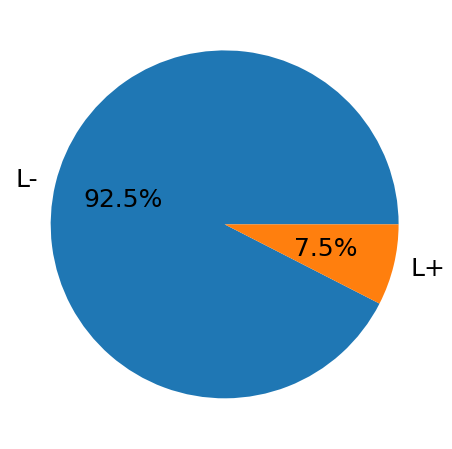

In [98]:
sizes = [20640, 1680]
fontdict_labels = {'fontsize': 25}
fig, ax = plt.subplots(figsize=(8,8))
color_palette = ['#1e81b0', '#e28743', '#9BC1BC', '#5CA4A9', '#E6EBE0']
color_palette = ['#5CA4A9', '#ED6A5A', '#9BC1BC', '#5CA4A9', '#E6EBE0']
ax.pie(sizes, labels=["L-","L+"],
        autopct='%1.1f%%', textprops=fontdict_labels)
plt.show()

NameError: name 'fpath' is not defined

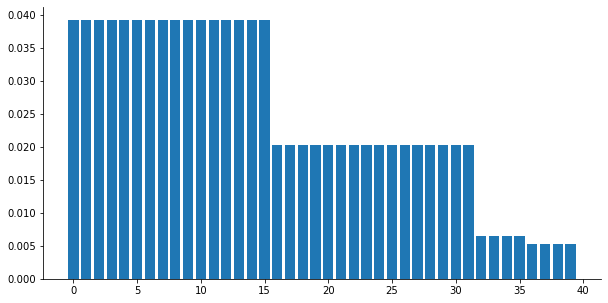

In [100]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = positive_ar.rname.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('ID resource', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of access to resources in $L^+$.", size="xx-large",  font=fpath2, x=0.29, y=1, parse_math=True)
plt.savefig("HC-AccessDistribution.svg")
plt.show()

### University

In [124]:
policy_un = [
    [
        [0,"type", "gradebook"],
        [1, "crsTaken", "csr"]
    ],
    [
        [0,"type", "gradebook"],
        [1, "crsTaught", "csr"]
    ],
    [
        [0, "position", "faculty"],
        [0,"type", "gradebook"],
        [1, "crsTaught", "csr"]
    ],
    [
        [0, "departmentu", "registrar"],
        [0, "type", "roster"]
    ],
    [
        [0, "position", "faculty"],
        [0, "type", "roster"],
        [1, "crsTaught", "csr"]
    ],
    [
        [0, "type", "transcript"],
        [1, "uname", "student"]
    ],
    [
        [0, "isChair", 1],
        [0, "type", "transcript"],
        [1, "department", "departmentu"]
    ],
    [
        [0, "departmentu", "registrar"],
        [0, "type", "transcript"],
    ],
    [
        [0, "type", "application"],
        [1, "uname", "student"]
    ],
    [
        [0, "departmentu", "admissions"],
        [0, "type", "application"],
    ]
]

In [125]:
# Load user and resource data
filepath = "../data/UN-users.csv"
df_users = pd.read_csv(filepath) # Users
#df_users = df_users[df_users.columns[1:]] # remove the rname column
df_users = df_users.drop_duplicates() # Remove deplicated users

filepath = "../data/UN-res.csv"
df_res = pd.read_csv(filepath)  # Resources
#df_res = df_res[df_res.columns[1:]]
df_res = df_res.drop_duplicates() # Remove deplicated users

print(df_users.info(), df_res.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uname        101 non-null    object
 1   position     101 non-null    object
 2   departmentu  101 non-null    object
 3   crsTaken     101 non-null    object
 4   crsTaught    101 non-null    object
 5   isChair      101 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 5.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 277 entries, 0 to 276
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   rName       277 non-null    object
 1   type        277 non-null    object
 2   student     277 non-null    object
 3   department  277 non-null    object
 4   csr         277 non-null    object
dtypes: object(5)
memory usage: 13.0+ KB
None None


In [126]:
access_log = []
for user in df_users.values:
    for res in df_res.values:        
        access_log.append(list(user) + list(res))
        
access_log = pd.DataFrame(access_log)
access_log.columns = df_users.columns.append(df_res.columns)
access_log

,uname,position,departmentu,crsTaken,crsTaught,isChair,rName,type,student,department,csr
0,applicant1,applicant,none,none,none,0,cs101gradebook,gradebook,none,cs,cs101
1,applicant1,applicant,none,none,none,0,cs601gradebook,gradebook,none,cs,cs601
2,applicant1,applicant,none,none,none,0,cs602gradebook,gradebook,none,cs,cs602
3,applicant1,applicant,none,none,none,0,cs101gradebooke,gradebook,none,ee,cs101
4,applicant1,applicant,none,none,none,0,cs601gradebooke,gradebook,none,ee,cs601
...,...,...,...,...,...,...,...,...,...,...,...
27972,admissions1,staff,admissions,none,none,0,csStu1application,application,csStu80,none,none
27973,admissions1,staff,admissions,none,none,0,csStu1application,application,csStu81,none,none
27974,admissions1,staff,admissions,none,none,0,csStu1application,application,csStu82,none,none
27975,admissions1,staff,admissions,none,none,0,csStu1application,application,csStu83,none,none


In [128]:
false_negs = []
positive_ar = []
for row in access_log.iloc:
    # Evaluation
    denies_count = 0    
    for rule in policy_un:
        res = True

        for item_rule in rule:    
            
            if item_rule[0] == 0:# Check type of typle => Attr=Value
                if row[item_rule[1]] != item_rule[2]:
                    res = False
                    break
            if item_rule[0] == 1: # => attr1.val = attr2.val
                
                if row[item_rule[1]] != row[item_rule[2]]:
                    res = False
                    break
            if item_rule[0] == 2: # val1 in {val1, val2, val3}
                if not row[item_rule[1]] in row[item_rule[2]]:
                    res = False
                    break
        if res == False:
            denies_count += 1
    if denies_count == len(policy_un):        
        false_negs.append(row)
    else:
        positive_ar.append(row)

false_negs = pd.DataFrame(false_negs)
positive_ar = pd.DataFrame(positive_ar)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
print("FN;", len(false_negs), "\t\tTP:", len(positive_ar))


FN; 26955 		TP: 1022


In [129]:
false_negs.to_csv("../data/UN-ALL-negative_ar.csv")
positive_ar.to_csv("../data/UN-ALL-positive_ar.csv")

del false_negs
del positive_ar

In [133]:
positive_ar = pd.read_csv("../data/UN-ALL-positive_ar.csv")

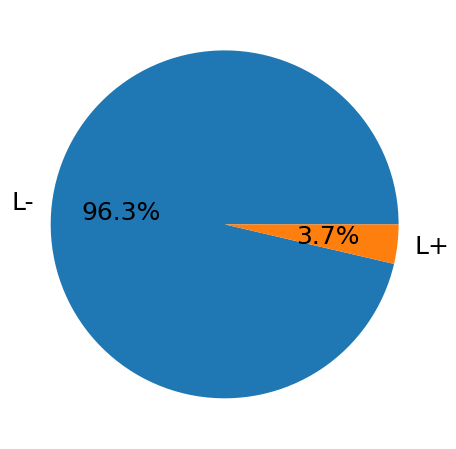

In [130]:
sizes = [26955, 1022]
fontdict_labels = {'fontsize': 25}
fig, ax = plt.subplots(figsize=(8,8))
color_palette = ['#1e81b0', '#e28743', '#9BC1BC', '#5CA4A9', '#E6EBE0']
color_palette = ['#5CA4A9', '#ED6A5A', '#9BC1BC', '#5CA4A9', '#E6EBE0']
ax.pie(sizes, labels=["L-","L+"],
        autopct='%1.1f%%', textprops=fontdict_labels)
plt.show()

NameError: name 'fpath' is not defined

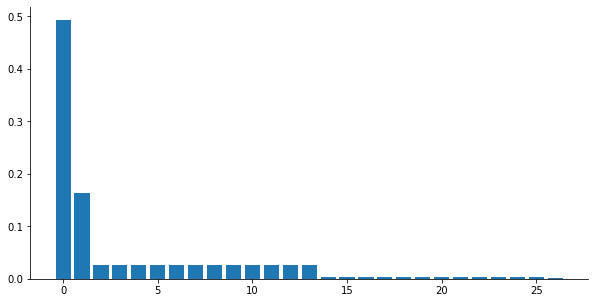

In [135]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines[['right', 'top']].set_visible(False)
access_distri = positive_ar.rName.value_counts(normalize=True)
ax.bar(range(len(access_distri)), access_distri)
ax.set_xlabel('ID resource', loc="left", size="large", font=fpath)
ax.set_ylabel('$P_k$', loc="top", size="large", font=fpath, parse_math=True)
ax.yaxis.set_label_coords(-0.08,0.95)
#ax.set_title("Linear Binning", loc='left', size="x-large", family='monospace', x=-0, y=1, alpha=0.5)
ax.set_title("Distribution of access to resources in $L^+$.", size="xx-large",  font=fpath2, x=0.29, y=1, parse_math=True)
plt.savefig("HC-AccessDistribution.svg")
plt.show()